참고사이트 : https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# 데이터 로더를 위한 데이터 경로 csv파일 만들기.
from pandas import DataFrame, Series
import pandas as pd
import glob
import re
import torchaudio

techniques = ['belt','breathy','lip_trill','vibrato','vocal_fry'] # ['fast_forte','fast_piano', 'forte','inhaled',  'messa','pp','slow_forte','slow_piano','spoken','trill']
train_singers = ['f1','f3','f4','f5','f6','f7','f9',"m1","m2","m4","m6","m7","m8","m9","m11"]
test_singers = ['f2','f8',"m3","m5","m10"]

train_df = pd.DataFrame(columns = {'path','singer','technique', 'length'})
test_df = pd.DataFrame(columns = {'path','singer','technique', 'length'})

# 여기서 train이랑 test나눠서 df 만들기
path = "/content/drive/MyDrive/Startup_Hackathon_Jarvis/data_by_technique/"
for technique in techniques:

  file_list =  glob.glob(path + technique + "/*.wav")

  for i in file_list:
    singer = re.findall(r'[mf][0-9]', i)
    sig, sr = torchaudio.load(i)
    length = sig.shape[1]/sr

    if not len(singer): continue

    if singer[0] in test_singers:
      test_df = test_df.append({'path': i,'singer': singer[0],'technique': technique,'length' : length}, ignore_index = True)
    
    elif singer[0] in train_singers:
      train_df = train_df.append({'path': i,'singer': singer[0],'technique': technique,'length' : length}, ignore_index = True)

train_df.to_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/train_df.csv")
test_df.to_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/test_df.csv")

# 0) EDA

In [ ]:
train_df.head()

,length,technique,singer,path
0,6.617279,belt,f9,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
1,4.958594,belt,f9,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
2,6.157279,belt,f9,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
3,7.021859,belt,f7,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
4,9.040091,belt,f7,/content/drive/MyDrive/Startup_Hackathon_Jarvi...


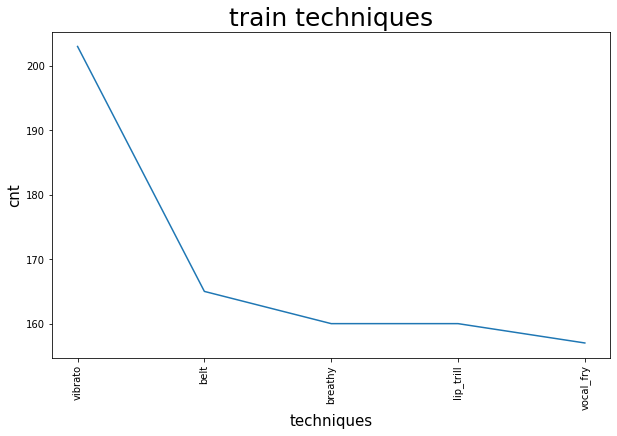

In [ ]:
tmp = train_df["technique"].value_counts()
fig = plt.figure(figsize=(10,6))
plt.plot(tmp)
plt.title("train techniques", fontsize = 25)
plt.xlabel("techniques", fontsize =15)
plt.ylabel("cnt", fontsize = 15)
plt.xticks(rotation = 90)
fig.show() 

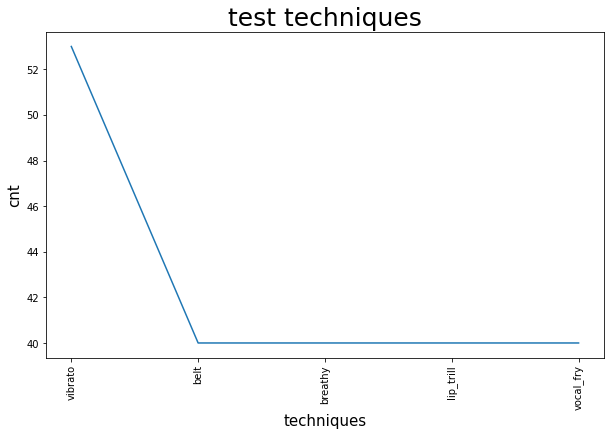

In [ ]:
tmp = test_df["technique"].value_counts()
fig = plt.figure(figsize=(10,6))
plt.plot(tmp)
plt.title("test techniques", fontsize = 25)
plt.xlabel("techniques", fontsize =15)
plt.ylabel("cnt", fontsize = 15)
plt.xticks(rotation = 90)
fig.show()

In [ ]:
train_df['length'].describe()

count    845.000000
mean       9.245670
std        4.960336
min        3.508186
25%        6.682925
50%        8.260816
75%       10.230794
max       48.102449
Name: length, dtype: float64

# 1) Data Util

In [ ]:
# Read audio from a file
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from pandas import DataFrame, Series
import pandas as pd
import numpy as np

class AudioUtil():
  # Load an audio file. Return the signal as a tensor and the sample rate
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  @staticmethod
  def standardize(aud):
    sig, sr = aud
    mean = sig.mean(axis = 1)
    std = sig.std(axis = 1)
    standardized_sig = (sig - mean) / std
    return (standardized_sig, sr)

  # Convert to two channels
  # Convert the given audio to the desired number of channels
  @staticmethod
  def rechannel(aud, new_channel):
    sig,sr = aud

    if(sig.shape[0] == new_channel):
      return aud # Nothing to do

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1,:]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig,sig])

    return (resig, sr)
    
  # Standardize sampling rate
  # 보통은 44100Hz로 데이터를 구성하며 이는 1초의 오디오가 44100 크기의 배열을 가지는 음성 파일을 뜻함. 
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # Resize to the same lenth
  @staticmethod
  def pad_trunc(aud, max_ms): # our papers max_ms == 3000ms
    sig, sr = aud
    num_rows, sig_len = sig.shape # 2, 291822
    max_len = sr//1000 * max_ms # 44 * 3000 == 132000

    if (sig_len > max_len):
      ####### 이부분 수정 필요 ######
      # 현재 우리는 non-overlapping하게 3초씩 데이터 truncation한거라 이에 맞게 코드 수정 요함. 
      sig = sig[:,:max_len]
    
    elif (sig_len < max_len):
      pad_begin_len = random.randint(0,max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
    return (sig, sr)

  # Mel Spectrogram
  # Generate a Spectrogram
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    # n_fft = 한번 fft를 해 줄 만큼의 sequence 길이. length of the windowed signal after padding with zeros. 
    # hop_length : window간의 거64리
    # win_length : window길이
    # mel filter bank를 short time Fourier Transform한 결과에 곱한 후 db로 magnitude를 바꿔 준다면 mel spectrogram완성.
    # n_mels : Number of mel filterbanks.
    # Mel-filter의 기본 아이디어는 사람의 청력은 1000Hz 이상의 frequency에 대해서는 덜 민감하므로 1000Hz까지는 Linear하게 그 이상은 Log scale로 변환해주자! 이다. 
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    ##### 더 밝게 mel-spectrogram을 만들어주기 위함. 
    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db = top_db)(spec)
    return spec

  @staticmethod
  def spectro_preprocessing(spec):
    

    return 

# 2) Data Loader


In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

class SoundDS(Dataset):
  def __init__(self, df):
    self.df = df
    self.duration = 3000
    self.sr = 44100
    self.channel = 1 # 논문에서는 channel 1, 3*44100짜리 데이터는 그냥 audio데이터

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    audio_file = self.df.loc[idx, 'path']
    label = self.df.loc[idx, 'technique']
    
    aud = AudioUtil.open(audio_file)
    standardize_aud = AudioUtil.standardize(aud)
    reaud = AudioUtil.resample(standardize_aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    sgram = AudioUtil.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
    # aug_sgram = AudioUtil.spectro_augment(sgram)
    return sgram, label

### 데이터 확인

In [ ]:
import matplotlib.pyplot as plt
import librosa

def plot_spectrogram(specgram, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

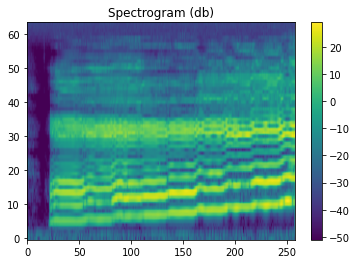

torch.Size([1, 64, 258])


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/test_df.csv")

tmpp = train_df.loc[0,'path']
tmpl = train_df.loc[0,'technique']
aud = AudioUtil.open(tmpp)
reaud = AudioUtil.resample(aud, 44100)
rechan = AudioUtil.rechannel(reaud,1)
dur_aud = AudioUtil.pad_trunc(rechan, 3000)
sgram = AudioUtil.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
plot_spectrogram(sgram[0])
print(sgram.shape)

# 3) Training

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/test_df.csv")

train_ds = SoundDS(train_df)
test_ds = SoundDS(test_df) 
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True) # [64, 1, 64, 258]
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True) # (batch_sz, num_channels, Mel freq_bands, time_steps)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=5)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=10   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, train_dl)